In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.cm as cm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
xyz = pd.read_table("06_tx_1965-2023_jrk.xyz", delim_whitespace=True)

In [3]:
xyz["year"] = xyz["T"].str[-4:].astype(int)

In [4]:
xyz

,X,Y,Z,T,loc,year
0,109682.41,558181.19,3.77,5-8-1965,900,1965
1,109677.53,558180.09,3.63,5-8-1965,900,1965
2,109672.65,558179.00,3.55,5-8-1965,900,1965
3,109667.77,558177.91,3.41,5-8-1965,900,1965
4,109662.89,558176.82,3.16,5-8-1965,900,1965
...,...,...,...,...,...,...
1380678,117558.08,579018.26,-1.44,3-4-2023,3081,2023
1380679,117551.46,579025.77,-1.70,3-4-2023,3081,2023
1380680,117544.85,579033.27,-1.88,3-4-2023,3081,2023
1380681,117538.24,579040.77,-2.14,3-4-2023,3081,2023


## Part 1: Plotting the coastline of Texel

In [6]:
def plot_all_points(): 
    plt.figure()
    plt.plot(xyz["X"], xyz["Y"])
    plt.show()

In [7]:
def coastline(baseline, steps): 

    years = [year for year in xyz["year"].unique()]
    
    for year in years: 
        concat_rows = []
        if year == baseline: 
            data_year = xyz[xyz["year"] == year]
            locations = [location for location in data_year["loc"].unique()]
            for location in locations:  
                data_loc = data_year[data_year["loc"] == location]
                index_highest = data_loc['Z'].idxmax()
                concat_rows.append(data_loc.loc[index_highest, :].copy())
    
            baseline += steps  
            data_highest = pd.DataFrame(concat_rows)
            
            # Step 1: Convert RD (X, Y) to Latitude/Longitude
            # Define the transformer from RD (EPSG:28992) to WGS84 (EPSG:4326)
            transformer = Transformer.from_crs("EPSG:28992", "EPSG:4326")
            
            # Step 2: Apply the transformation to all X and Y coordinates in the DataFrame
            latlon_coords = data_highest.apply(lambda row: transformer.transform(row["X"], row["Y"]), axis=1)
            data_highest["Latitude"], data_highest["Longitude"] = zip(*latlon_coords)
            
            # Step 3: Map scatter points with basemap of Texel
            map = Basemap(projection='merc', llcrnrlon=4.65, llcrnrlat=52.95, urcrnrlon=4.9, urcrnrlat=53.2, resolution='h')
            map.drawcoastlines()
            map.fillcontinents(color='lightgray')
            
            x, y = map(data_highest["Longitude"].values, data_highest["Latitude"].values)
            map.scatter(x, y, c=data_highest["Z"], s=25, cmap='viridis', edgecolors='k', zorder=5)
            plt.colorbar(label="Z (Altitude)")
            plt.title(f'Coastline Texel in {year}')
            plt.show()

## Part 2: Sediment budget over time

In [54]:
def rsp(data, location, end_year): 
    """
    Retrieve RSP line for location, based on year 2020
    """
    rsp_loc = 0
    years = [year for year in data["year"].unique()]
    for year in years: 
        if year == end_year: 
            data_year = data[data["year"] == year]
            data_loc = data_year[data_year["loc"] == location]
            rsp_loc = data_loc["X"].max()
            break
            
    return rsp_loc

In [55]:
def regional_sediment_budget(data, dune_threshold, region_threshold, region_name): 
    """
    Computes sediment budget per year
    """
    volume_development = pd.DataFrame(columns=['Year', f"{region_name} Dune Volume"])
    years = [year for year in data["year"].unique()]
    for year in years: 
        if year != 2023: 
            data_year = data[data["year"] == year]
            locations = [location for location in data_year["loc"].unique()]
            
            region = []
            for location in locations:
                if location >= region_threshold[0] and location <= region_threshold[1]:
                    region.append(location)
                else:
                    pass
                    
            volume_dunes = 0
            for raai in region:  
                data_loc = data_year[(data_year["loc"] == raai)]
                rsp_loc = rsp(xyz, raai)
                data_rsp = data_loc[data_loc["X"] <= rsp_loc]
                data_positive = data_rsp[data_rsp["Z"] > dune_threshold]
                volume_location = 0
                for i in range(1, len(data_positive)):
                    # Calculate the area of the base formed by the X and Y coordinates
                    base_area = np.abs((data_positive['X'].iloc[i] - data_positive['X'].iloc[i-1]) * 
                                       (data_positive['Y'].iloc[i] - data_positive['Y'].iloc[i-1]))
                    
                    # Average height between the two points
                    avg_height = (data_positive['Z'].iloc[i] + data_positive['Z'].iloc[i-1]) / 2
                    
                    # Volume contribution from this segment
                    volume_location += base_area * avg_height
    
                volume_dunes += volume_location
                
            # Create a temporary DataFrame for the new row
            new_row_df = pd.DataFrame({'Year': [year], f"{region_name} Dune Volume": [volume_dunes]})
            volume_development = pd.concat([volume_development, new_row_df], ignore_index=True)
        
    return volume_development

In [49]:
budget_zuidwest = regional_sediment_budget(data = xyz, dune_threshold = 3, region_threshold = [900,1298], region_name="ZuidWest")
budget_nationaal_park = regional_sediment_budget(data = xyz, dune_threshold = 3, region_threshold = [1312,1853], region_name="Nationaal Park")
budget_koog = regional_sediment_budget(data = xyz, dune_threshold = 3, region_threshold = [1873,2091], region_name="Koog")
budget_slufter = regional_sediment_budget(data = xyz, dune_threshold = 3, region_threshold = [2111,3081], region_name="Slufter")

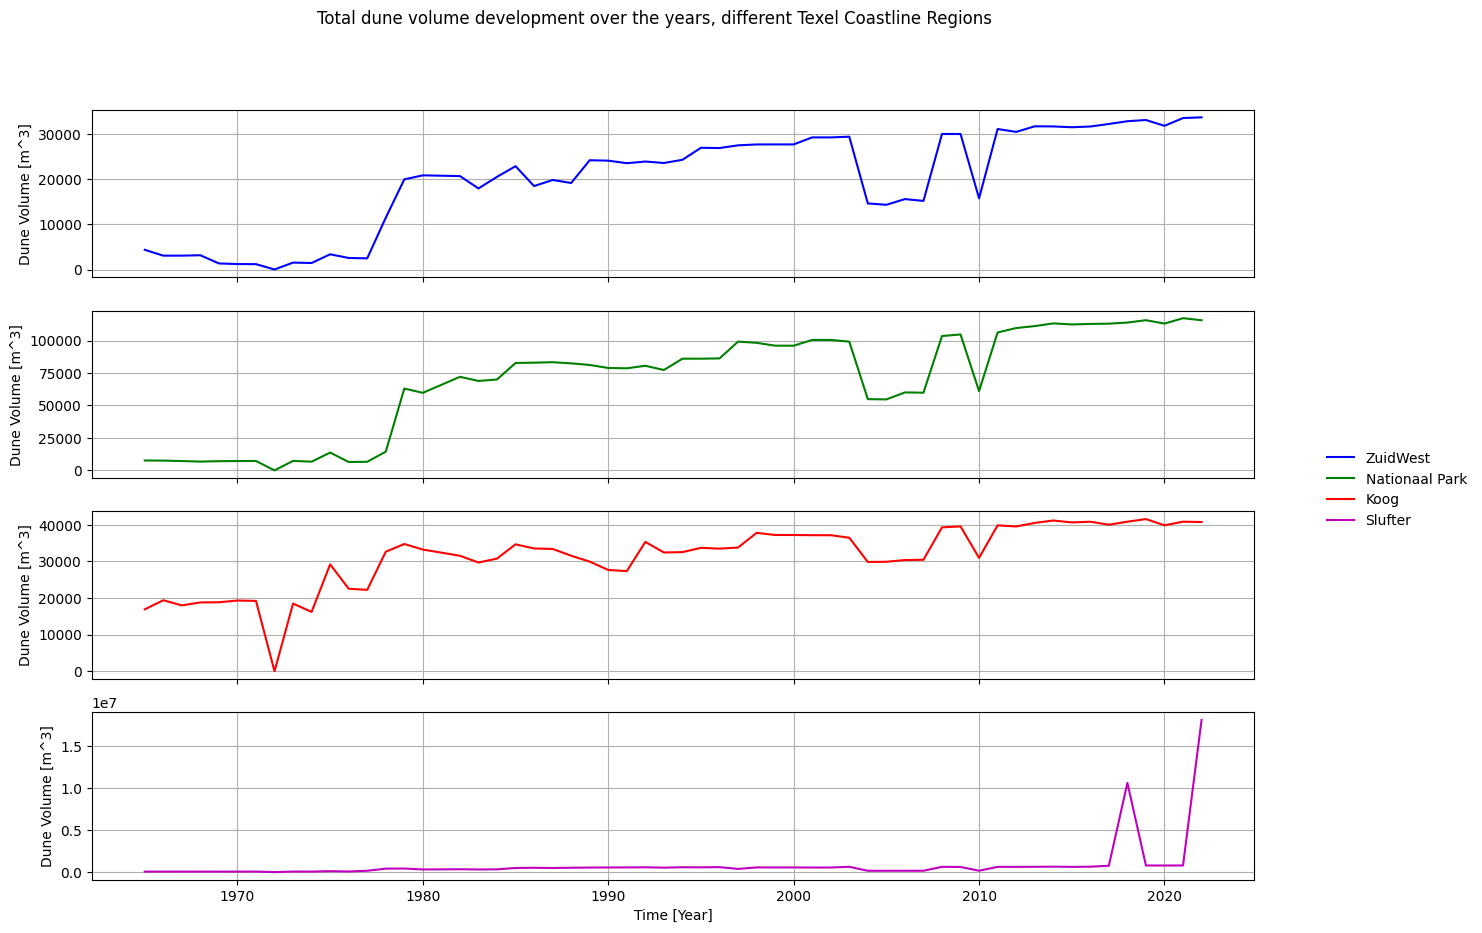

In [98]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15, 10))
plt.suptitle(f"Total dune volume development over the years, different Texel Coastline Regions")

ax1.plot(budget_zuidwest["Year"], budget_zuidwest["ZuidWest Dune Volume"], color='b', label = 'ZuidWest')
ax2.plot(budget_nationaal_park["Year"], budget_nationaal_park["Nationaal Park Dune Volume"], color='g', label = 'Nationaal Park')
ax3.plot(budget_koog["Year"], budget_koog["Koog Dune Volume"], color='r', label='Koog')
ax4.plot(budget_slufter["Year"], budget_slufter["Slufter Dune Volume"], color='m', label='Slufter')
ax1.grid()
ax1.set_ylabel('Dune Volume [m^3]')
ax2.grid()
ax2.set_ylabel('Dune Volume [m^3]')
ax3.grid()
ax3.set_ylabel('Dune Volume [m^3]')
ax4.grid()
ax4.set_ylabel('Dune Volume [m^3]')
ax4.set_xlabel('Time [Year]')
plt.figlegend(loc = 'right', bbox_to_anchor=(1.05,0.5), frameon=False)
plt.show()

In [75]:
def sediment_budget_per_location(data = xyz, threshold = 3, baseline=1980, steps=5, stop = 2023, jarkus = 900): 
    """
    Calculates the sediment budget per location and visualises the results. 
    """
    years = [year for year in data["year"].unique()]
    plt.figure(figsize=(10, 6))
    total_plots = (2020 - baseline)/steps
    nr_plots = 0
    for year in years: 
        if year==baseline: 
            if year != stop: 
                baseline += steps 
                data_year = data[data["year"] == year]
                locations = [location for location in data_year["loc"].unique()]
                for location in locations: 
                    if location == jarkus: 
                        data_loc = data_year[data_year["loc"] == location]
                        rsp_loc = rsp(xyz, jarkus, (stop-1))
                        data_rsp = data_loc[data_loc["X"] <= rsp_loc]
                        data_positive = data_rsp[data_rsp["Z"] > threshold]
                        volume_location_per_year = 0
                        for i in range(1, len(data_positive)):
                            # Calculate the area of the base formed by the X and Y coordinates
                            base_area = np.abs((data_positive['X'].iloc[i] - data_positive['X'].iloc[i-1]) * 
                                               (data_positive['Y'].iloc[i] - data_positive['Y'].iloc[i-1]))
                            
                            # Average height between the two points
                            avg_height = (data_positive['Z'].iloc[i] + data_positive['Z'].iloc[i-1]) / 2
                            
                            # Volume contribution from this segment
                            volume_location_per_year += base_area * avg_height
    
                        col = cm.viridis(nr_plots / total_plots)
                        col = cm.get_cmap('RdYlGn')(nr_plots / total_plots)
                        plt.plot(data_rsp["X"], data_rsp["Z"], color=col, label=f'{year}')
                        nr_plots += 1
        

    plt.grid()
    plt.title(f"Jarkus raai {jarkus} for different years")
    plt.axhline(y=3, color='black', linestyle='--', label='Dunes')
    plt.axvline(x=rsp_loc, color='black', linestyle='-.', label='RSP')
    plt.legend()
    plt.show()

/var/folders/g4/8z1prdqs5l3dj5xzv765t_sc0000gn/T/ipykernel_14959/813064467.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  col = cm.get_cmap('RdYlGn')(nr_plots / total_plots)


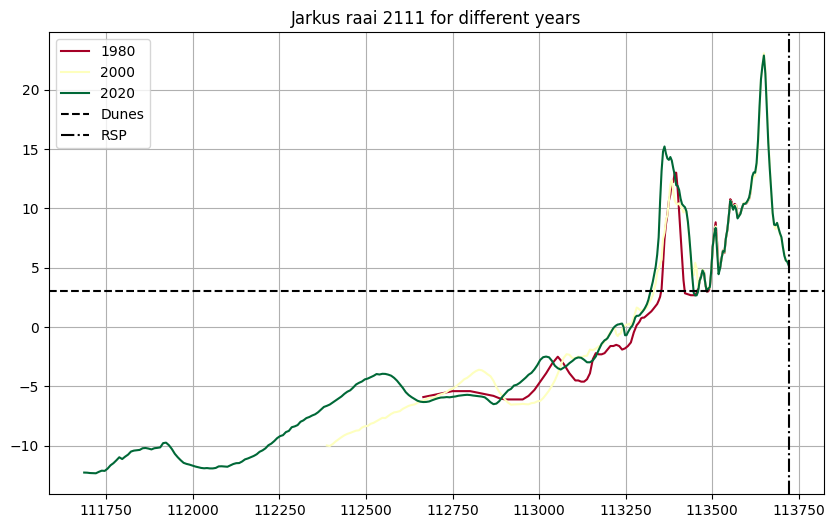

In [78]:
sediment_budget_per_location(baseline=1980, steps=20, stop=2001, jarkus=2111)

In [116]:
def sediment_budget_per_location(data=xyz, threshold=3, first_year=1980, last_year=2021, steps=5, locations=[900, 1763, 1972, 2400], 
                                 location_region = ["South-West Texel", "National Park", "De Koog", "Slufter"]):
    """
    Calculates the sediment budget per four locations and visualizes the results.
    """
    years = np.arange(first_year, last_year + 1, steps)  
    fig, axes = plt.subplots(2, 2, sharex=False, figsize=(15, 10))
    axes = axes.ravel()  
    total_plots_per_subplot = len(years)  

    for i, ax in enumerate(axes):
        location = locations[i]
        region = location_region[i]
        data_loc = data[data["loc"] == location] 
        rsp_loc = rsp(xyz, location, (last_year - 1))  
        data_rsp = data_loc[data_loc["X"] <= rsp_loc]  
        
        nr_plots = 0  
        
        for year in years:
            data_year = data_rsp[data_rsp["year"] == year]  
            if not data_year.empty: 
                col = cm.get_cmap('RdYlGn')(nr_plots / total_plots_per_subplot)
                ax.plot(data_year["X"], data_year["Z"], color=col, label=f'{year}')
                ax.set_title(f"Location {location}, {region}")
                
                nr_plots += 1

        ax.axhline(y=threshold, color='black', linestyle='--', label='Dune area')  
        ax.axvline(x=rsp_loc, color='black', linestyle='-.', label='RSP')  
        ax.set_xlabel('Distance')
        ax.set_ylabel('Height relative to NAP')
        ax.grid(True)  # Enable grid
        ax.legend(title="Years")  # Add legend to the current subplot
    plt.suptitle("Coastal development over the years for different locations")
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


/var/folders/g4/8z1prdqs5l3dj5xzv765t_sc0000gn/T/ipykernel_14959/3020102623.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  col = cm.get_cmap('RdYlGn')(nr_plots / total_plots_per_subplot)


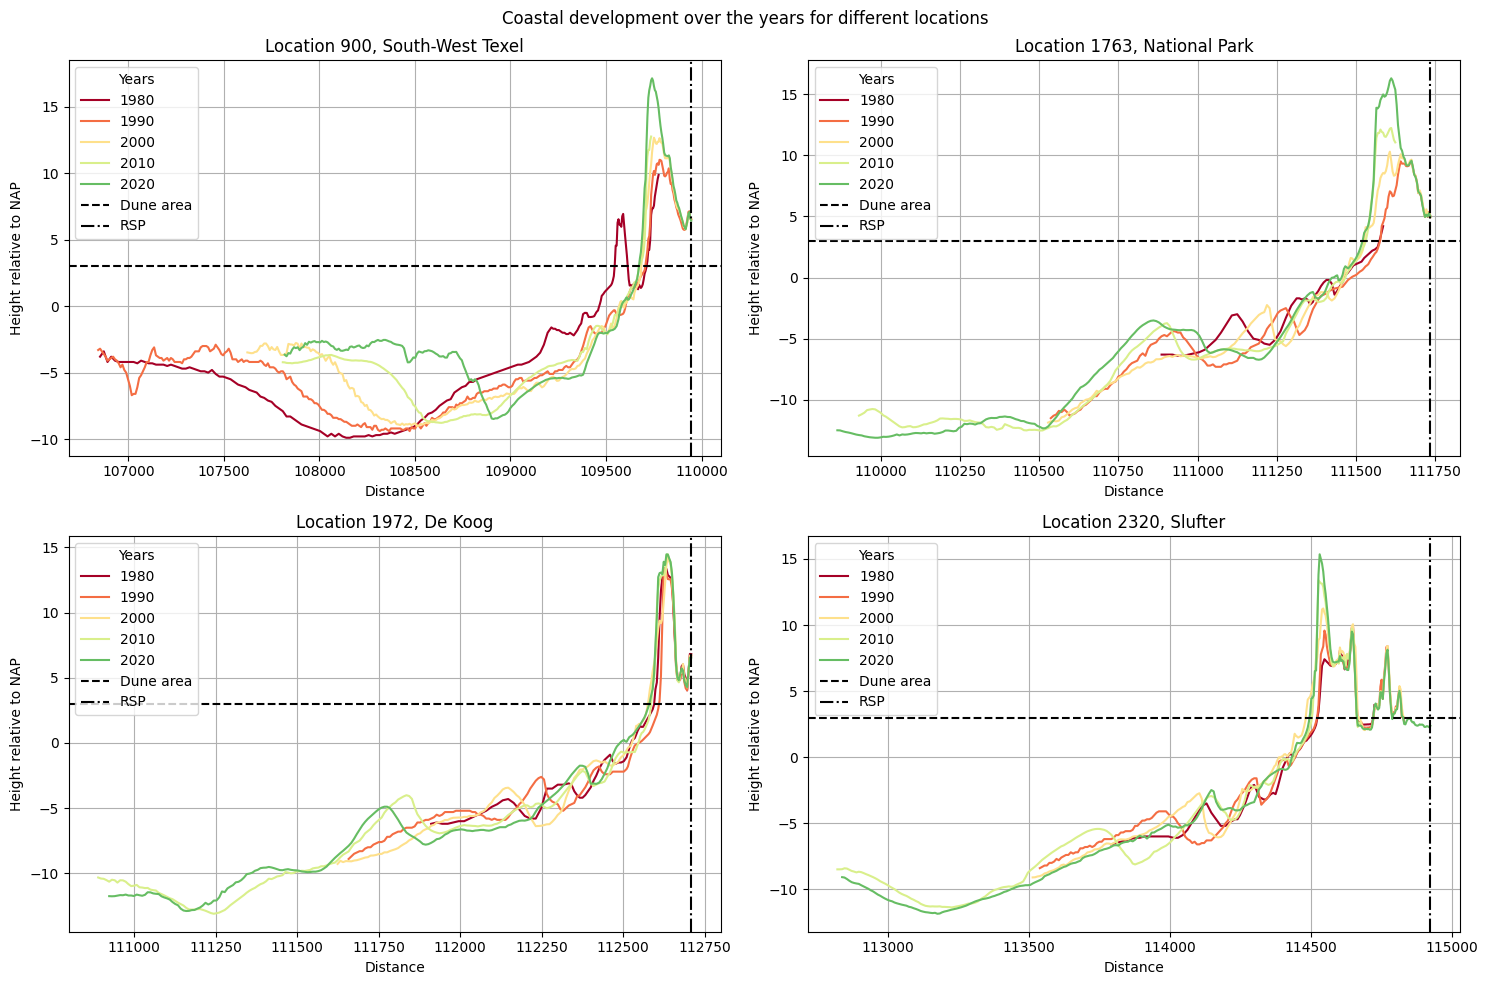

In [117]:
sediment_budget_per_location(first_year=1980, last_year = 2021, steps=10, locations = [900, 1763, 1972, 2320])